<b id="top"></b> 
# Demo Notebook for Huawei Public 2025 data release

This notebook explains how to load an analyze the Huawei Public 2025 data. 

**Big data tools:** We include a section about how to analyze large amounts of data efficiently using Dask, a parallelized version of Pandas that can be simply installed using conda or pip.

You may want to run sections of this notebook separately if you have limited memory available.

Table of contents links may only work when you clone the repo.

### Table of Contents

1. [Quick start: CDFs of cold starts per region](#cdfs)

2. [Plotting time series and quantiles](#quantiles)
   
   2.1. [Quick start: Plotting requests per minute](#quickstart2)

   2.2. [Function naming conventions](#conventions)
   
   2.3. [Plotting resource usage](#resourceusage)

   2.4. [Plotting more time series metrics](#moretimeseries)


3. [Region 2 with runtimes and trigger types](#runtimetriggertype)

   3.1. [Plotting runtime and trigger type](#plottingruntimetriggertype)

   3.2. [Plotting cold start CDF by runtime](#runtimecdf)

4. [Per-request analysis](#perrequest)
   
5. [Big data tools: Per-request analysis with Dask](#perrequestdask)

   5.1. [Per-request level CDF](#perrequestcdf)

   5.2. [Grouping per-request logs by funcID](#requestgrouping)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from glob import glob
from tqdm import tqdm
import seaborn as sns
import gc
sns.set_theme()

Always run this cell to set up

In [2]:
# Define regions we want to analyze
region_names = ['R1', 'R2', 'R3', 'R4', 'R5']

# Define root for quantiles
rt = '../datasets/cold_start_dataset/quantiles'

# Define root for cold starts
rt_cold_start = '../datasets/cold_start_dataset/cold_start'

# Define root for runtime and trigger type file
rt_funcID_runtime_triggerType = '../datasets/cold_start_dataset/runtime_triggerType/df_funcID_runtime_triggerType.csv'

<a id="cdfs"></a>
## 1. Quick start: CDFs of cold starts per region 

Quickly plot CDFs of cold starts for all regions. <a href="#top">[back to top]</a>

In [3]:
# Read cold starts
df_list_outer = []
for region_name_i in region_names:
    print(f'Reading {region_name_i}')
    filenames_list_i = sorted(glob(rt_cold_start+f'/{region_name_i}/*.csv'))
    dfs_list = []
    for filename_i in tqdm(filenames_list_i):
        df_i = pd.read_csv(filename_i)
        dfs_list.append(df_i)
    df_xx = pd.concat(dfs_list)
    df_xx['region'] = region_name_i
    df_list_outer.append(df_xx)
    del dfs_list, df_xx 
    gc.collect()

df_all_cold_starts = pd.concat(df_list_outer)
df_all_cold_starts

Reading R1


100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


Reading R2


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


Reading R3


100%|██████████| 31/31 [00:00<00:00, 40.62it/s]


Reading R4


100%|██████████| 31/31 [00:04<00:00,  7.37it/s]


Reading R5


100%|██████████| 31/31 [00:02<00:00, 14.92it/s]


,day,time,clusterName,funcName,userID,requestID,totalCost_cold_start,podAllocationCost,deployCodeCost,deployDependencyCost,schedulingCost,podID,region
0,0,0.104,1,332,439,5d990e049d11666fa09b51971c30877a951a137dc01181...,0.911090,0.000590,0.001,0.000,0.909500,pool22-300-128-0006319574,R1
1,0,0.226,2,462,431,3e1e354e1640b47e684061bd847dd87792fd07104e369e...,0.193592,0.000786,0.042,0.000,0.150806,pool22-300-128-0005156468,R1
2,0,0.245,2,2016,556,1b8a1286ba72b9f3636d4b1c98909965139a8bd795eb79...,0.201389,0.000642,0.037,0.000,0.163747,pool24-600-512-0003876526,R1
3,0,0.248,1,2067,454,059766cc9948334ea8ddb1b0e1b68053c57a577e783cd3...,1.696061,0.000724,0.052,0.000,1.643337,pool22-300-128-0006740179,R1
4,0,0.373,3,84,602,eb168d8932887d6e2c5d024d2e9e42ec2770970c4dbbbf...,5.309122,0.015405,1.733,0.000,3.560717,pool26-1000-1024-0006851174,R1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25340,30,2678350.991,3,224,201,db34396a82978dc0563ea33e3046d86407fb61226d22c4...,6.913106,0.027074,0.002,4.322,2.562032,pool35-6600-8192-0000463009,R5
25341,30,2678378.535,3,387,134,afb70ac76af0b0777ff7f36a15ef01a1b33dab553f6ba7...,1.448237,0.026551,0.003,0.422,0.996686,pool34-3400-4096-0000290450,R5
25342,30,2678382.467,3,402,119,ac1e62d3d81f2687b00fffbd84bf355fd1246de6ff3ca8...,0.394911,0.000124,0.002,0.000,0.392787,pool22-300-128-0000736130,R5
25343,30,2678383.461,4,56,353,798ea243d0f630e4d861f1dc1b404c44d0741d06e3eee2...,0.381081,0.000130,0.002,0.000,0.378951,pool23-400-256-0000710353,R5


<Axes: xlabel='totalCost_cold_start', ylabel='Probability'>

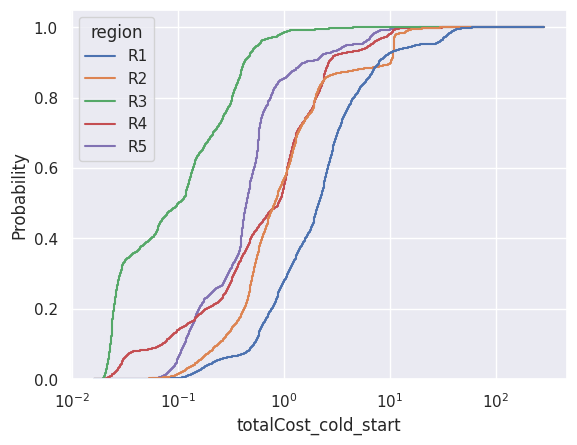

In [4]:
# Plot of cold start times per region
sns.histplot(data=df_all_cold_starts, 
             bins=500,
             fill=False,
             element="step",
             x='totalCost_cold_start', 
             hue='region', 
             stat='probability', 
             cumulative=True, 
             log_scale=[True,False], 
             common_norm=False)

<a id="quantiles"></a>
## 2. Plotting time series and quantiles
This section shows how to plot time series and quantiles for this dataset, as well as several naming conventions and common analyses.

<a href="#top">[back to top]</a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from glob import glob
from tqdm import tqdm
import seaborn as sns
import gc
sns.set_theme()

In [2]:
# Define root for quantiles
rt = '../datasets/cold_start_dataset/quantiles'

In [3]:
# Define region
region_name_i = 'R2'

<a id="quickstart2"></a>
### 2.1. Quick start: Plotting requests per minute
This section shows how to quickly plot requests per minute. <a href="#top">[back to top]</a>

In [4]:
rt_requests = f'{rt}/{region_name_i}/requests/*.csv'
filenames_i = sorted(glob(rt_requests))
print(f'Found {len(filenames_i)} requests files')

Found 31 requests files


In [5]:
# Select number of days to read (or None to read all)
n_days = None
dfs_list = []
for f_i in tqdm(filenames_i[:n_days]):
    df = pd.read_csv(f_i)
    dfs_list.append(df)
df_requests = pd.concat(dfs_list)
df_requests

100%|██████████| 31/31 [00:10<00:00,  2.92it/s]


,day,time,400---418---pool22-300-128,1531---418---pool22-300-128,343---1077---pool22-300-128,343---192---pool22-300-128,343---974---pool22-300-128,343---952---pool22-300-128,343---107---pool22-300-128,1263---582---pool23-400-256,...,2072---592---pool22-300-128,1835---1027---pool22-300-128,1740---726---pool22-300-128,267---274---pool22-300-128,1177---759---pool22-300-128,1533---1078---pool22-300-128,1247---418---pool22-300-128,1293---98---pool22-300-128,1859---251---pool22-300-128,591---795---pool22-300-128
0,0,0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,180,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,30,2678100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436,30,2678160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,30,2678220,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1438,30,2678280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Select function we want to visualize
funcID = '137---631---pool23-400-256'

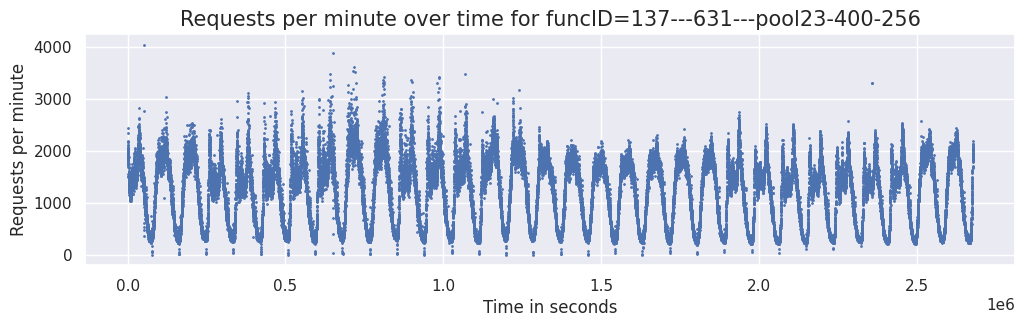

In [7]:
# Plot requests per minute
fig = plt.figure(figsize=(12, 3))
plt.scatter(df_requests['time'], df_requests[funcID], s=1)
plt.xlabel('Time in seconds')
plt.ylabel('Requests per minute')
plt.title(f'Requests per minute over time for funcID={funcID}', fontsize=15)
plt.show()

<a id="conventions"></a>
### 2.2. Function naming conventions
The cell below explains the naming conventions used in this dataset, including funcID, funcName, userID, and poolName. 

<a href="#top">[back to top]</a>

In [8]:
# Identify unique functions 
funcIDs_list = list(df_requests.columns)
funcIDs_list.remove('day')
funcIDs_list.remove('time')

# Create dataframe with funcIDs
df_summary = df_requests[funcIDs_list].sum().reset_index().rename({'index':'funcID', 0: 'requests'}, axis=1)

# First part of funcID is funcName
df_summary['funcName'] = df_summary['funcID'].str.split('---').str[0].astype(int)

# Second part of funcID is userID
df_summary['userID'] = df_summary['funcID'].str.split('---').str[1].astype(int)

# Third part of funcID is poolName
df_summary['poolName'] = df_summary['funcID'].str.split('---').str[2]

# poolName contains the cpu_limit (in millicores) and memory_limit (in MB) assigned to this function
df_summary['cpu_limit']= df_summary['poolName'].str.split('-').str[1].astype(int)
df_summary['memory_limit']= df_summary['poolName'].str.split('-').str[2].astype(int)

df_summary = df_summary.sort_values(by='requests', ascending=False)

df_summary

,funcID,requests,funcName,userID,poolName,cpu_limit,memory_limit
1213,88---337---pool26-1000-1024,8.531371e+09,88,337,pool26-1000-1024,1000,1024
1342,1529---631---pool23-400-256,1.172783e+09,1529,631,pool23-400-256,400,256
1348,1118---631---pool24-600-512,1.145816e+09,1118,631,pool24-600-512,600,512
978,1542---502---pool22-300-128,3.984803e+08,1542,502,pool22-300-128,300,128
975,1179---502---pool23-400-256,3.984757e+08,1179,502,pool23-400-256,400,256
...,...,...,...,...,...,...,...
2353,1642---478---pool22-300-128,1.000000e+00,1642,478,pool22-300-128,300,128
2388,220---797---pool22-300-128,1.000000e+00,220,797,pool22-300-128,300,128
2377,1269---330---pool22-300-128,1.000000e+00,1269,330,pool22-300-128,300,128
2386,1749---4---pool35-6600-8192,1.000000e+00,1749,4,pool35-6600-8192,6600,8192


In [9]:
# We consider funcID to be the unique function identifier
for colname in ['funcID', 'funcName', 'userID', 'poolName']:
    n_unique_i = df_summary[colname].nunique()
    print(f'{colname} has {n_unique_i} unique values')

funcID has 2418 unique values
funcName has 2148 unique values
userID has 1144 unique values
poolName has 27 unique values


<a id="resourceusage"></a>
### 2.3. Plotting resource usage
This section explains how to plot CPU usage, CPU limit, and CPU request. A similar approach can be used to visualize memory. Memory only has a limit, unlike CPU which has a request and a limit.

<a href="#top">[back to top]</a>

In [10]:
# Mapping of cpu_limit to cpu_request
dict_cpu_lim_to_req = {300: 100, 400: 125, 600: 300, 800: 375, 
                        1000: 500, 1200: 625, 1400: 750, 
                        1600: 875, 1800: 1000, 2200: 1250,
                        2600: 1500, 3000: 1750, 3400: 2000, 
                        6600: 4000, 8200: 5000, 13000: 6500, 25800: 12900}

In [11]:
# Define statistics we want to plot. We can plot quantiles as well as avg and std.
quantiles_list = [0, 25, 50, 90, 100, 'avg', 'std']

quantiles_list = [f'quantile_{item:003}' if isinstance(item, int) else item for item in quantiles_list]

print(quantiles_list)

metrics_dict = {
    'cpu_usage': dict.fromkeys(quantiles_list),
}

['quantile_000', 'quantile_025', 'quantile_050', 'quantile_090', 'quantile_100', 'avg', 'std']


In [12]:
# Read metrics
n_days = 3

metric_family_list = sorted(list(metrics_dict.keys()))

for metric_family in metric_family_list:
    print(metric_family)
    metric_subfamily_list = sorted(list(metrics_dict[metric_family].keys()))

    for submetric in tqdm(metric_subfamily_list):
        if submetric=='sum':
            rt_i = f'{rt}/{region_name_i}/{metric_family}/*.csv'
        else:
            rt_i = f'{rt}/{region_name_i}/{metric_family}_{submetric}/*.csv'

        filenames_i = sorted(glob(rt_i))

        dfs_list_i = []
        for f_i in filenames_i[:n_days]:
            df_ii = pd.read_csv(f_i)
            dfs_list_i.append(df_ii)
        df_i = pd.concat(dfs_list_i)

        metrics_dict[metric_family][submetric] = df_i

cpu_usage


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


In [13]:
# Select a function we want to visualize
funcID = '137---631---pool23-400-256'

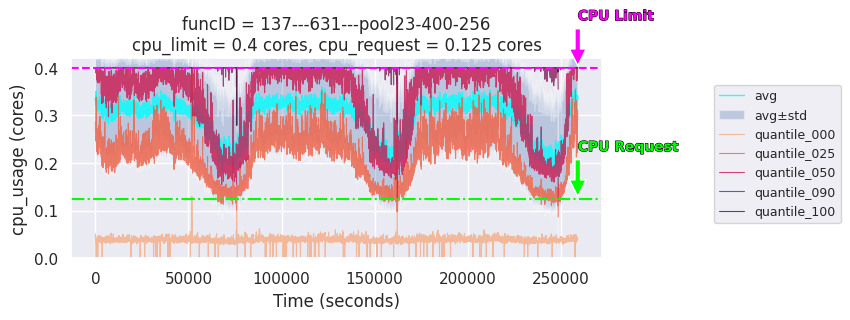

In [14]:
# Visualize CPU usage, limit, and request
cpu_limit_cores = float(funcID.split('---')[-1].split('-')[1])/1000
cpu_request_cores = dict_cpu_lim_to_req[int(cpu_limit_cores*1000)]/1000
alpha = 0.8
linewidth = 0.8
limit_color='magenta'
request_color='lime'

fig, ax = plt.subplots(1,1,figsize=(9,3.5))

metric_family_dict = metrics_dict['cpu_usage'].copy()

# Avg and std plots
ax.plot(metric_family_dict['avg']['time'], metric_family_dict['avg'][funcID], label = 'avg', c='cyan', alpha=0.8, linewidth=1)

std_upper = metric_family_dict['avg'][funcID] - metric_family_dict['std'][funcID]
std_lower = metric_family_dict['avg'][funcID] + metric_family_dict['std'][funcID]
ax.fill_between(metric_family_dict['avg']['time'], std_lower, std_upper, alpha=0.3, facecolor='b', label='avg±std')


# Quantile plots
q_list = sorted(metric_family_dict.keys())
q_list = [item for item in q_list if 'quantile' in item]

max_ylim = -9999
c_list = sns.color_palette('rocket_r', len(q_list))
for i, q_i in enumerate(q_list):
    df_q_i = metric_family_dict[q_i]
    ax.plot(df_q_i['time'], df_q_i[funcID], label = q_i.replace(metric_family,''), c=c_list[i], alpha=alpha, linewidth=linewidth)

    max_ylim_i = df_q_i[funcID].quantile(0.99)
    if max_ylim<max_ylim_i:
        max_ylim = max_ylim_i

ax.set_xlabel('Time (seconds)')

ax.legend(bbox_to_anchor=(1.2, 0.9), fontsize=9)

ax.set_ylim(None, max_ylim*1.05)
if ax.get_ylim()[0]<0:
    ax.set_ylim(0, max_ylim*1.05)

ax.set_ylabel('cpu_usage (cores)')

# Horizontal lines
plt.axhline(y=cpu_limit_cores, color=limit_color, linestyle='--', label='CPU Limit')
plt.axhline(y=cpu_request_cores, color=request_color, linestyle='-.', label='CPU Request')

# Add arrow and labels for "CPU Limit"
annotation = plt.annotate('CPU Limit', 
            xy=(metric_family_dict['avg']['time'].iloc[-1], cpu_limit_cores), 
            xytext=(metric_family_dict['avg']['time'].iloc[-1] + 0.5, cpu_limit_cores + 0.1),
            arrowprops=dict(facecolor=limit_color, shrink=0.05), fontsize=10, color=limit_color, fontweight='heavy')
# Add a black outline to the text
annotation.set_path_effects([path_effects.Stroke(linewidth=0.8, foreground='black'), 
                             path_effects.Normal()])
# Add arrow and labels for "CPU Request"
annotation = plt.annotate('CPU Request', 
            xy=(metric_family_dict['avg']['time'].iloc[-1], cpu_request_cores), 
            xytext=(metric_family_dict['avg']['time'].iloc[-1] + 0.5, cpu_request_cores + 0.1),
            arrowprops=dict(facecolor=request_color, shrink=0.05), fontsize=10, color=request_color, fontweight='heavy')
# Add a black outline to the text
annotation.set_path_effects([path_effects.Stroke(linewidth=0.8, foreground='black'), 
                             path_effects.Normal()])

title_str = f'funcID = {funcID}\ncpu_limit = {cpu_limit_cores} cores, cpu_request = {cpu_request_cores} cores'

plt.title(title_str)
plt.tight_layout()
plt.show()

In [15]:
del metric_family_dict
gc.collect()

3255

<a id="moretimeseries"></a>
### 2.4. Plotting more time series metrics
We can extend the code in the previous section to plot more of the metrics in our dataset. <a href="#top">[back to top]</a>

In [4]:
# Define statistics we want to plot. We can plot quantiles as well as avg and std.
quantiles_list = [0, 50, 90, 95, 'avg', 'std']

quantiles_list = [f'quantile_{item:003}' if isinstance(item, int) else item for item in quantiles_list]

print(quantiles_list)

metrics_dict = {
    'requests': dict.fromkeys(['sum']),
    'num_pods': dict.fromkeys(['sum']),
    'num_cold_starts': dict.fromkeys(['sum']),
    'cpu_usage': dict.fromkeys(quantiles_list),
    'memory_usage': dict.fromkeys(quantiles_list),

    'totalCost_frontend': dict.fromkeys(quantiles_list),
    'totalCost': dict.fromkeys(quantiles_list),
    'totalCost_cold_start': dict.fromkeys(quantiles_list),

    'workerCost': dict.fromkeys(quantiles_list),
    'frontendCost': dict.fromkeys(quantiles_list),
    'readBodyCost': dict.fromkeys(quantiles_list),

    'writeRspCost': dict.fromkeys(quantiles_list),
    'runtimeCost': dict.fromkeys(quantiles_list),
    'busCost': dict.fromkeys(quantiles_list),

    'requestBodySize': dict.fromkeys(quantiles_list),

    'podAllocationCost': dict.fromkeys(quantiles_list),
    'deployCodeCost': dict.fromkeys(quantiles_list),
    'deployDependencyCost': dict.fromkeys(quantiles_list),
    'schedulingCost': dict.fromkeys(quantiles_list),
}

['quantile_000', 'quantile_050', 'quantile_090', 'quantile_095', 'avg', 'std']


In [5]:
# Read time series of metrics, including quantiles
n_days = 3

metric_family_list = sorted(list(metrics_dict.keys()))

for metric_family in metric_family_list:
    print(metric_family)
    metric_subfamily_list = sorted(list(metrics_dict[metric_family].keys()))

    for submetric in tqdm(metric_subfamily_list):
        if submetric=='sum':
            rt_i = f'{rt}/{region_name_i}/{metric_family}/*.csv'
        else:
            rt_i = f'{rt}/{region_name_i}/{metric_family}_{submetric}/*.csv'

        filenames_i = sorted(glob(rt_i))

        dfs_list_i = []
        for f_i in filenames_i[:n_days]:
            df_ii = pd.read_csv(f_i)
            dfs_list_i.append(df_ii)
        df_i = pd.concat(dfs_list_i)

        metrics_dict[metric_family][submetric] = df_i


busCost


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


cpu_usage


100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


deployCodeCost


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


deployDependencyCost


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


frontendCost


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


memory_usage


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


num_cold_starts


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


num_pods


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


podAllocationCost


100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


readBodyCost


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


requestBodySize


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


requests


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


runtimeCost


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


schedulingCost


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


totalCost


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


totalCost_cold_start


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


totalCost_frontend


100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


workerCost


100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


writeRspCost


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


In [6]:
# Rank functions by their total number of requests
df_top = metrics_dict['requests']['sum'][metrics_dict['requests']['sum'].columns[2:]].sum().reset_index().rename(columns={'index':'funcID', 0:'num_requests'})
df_top = df_top.sort_values(by='num_requests', ascending=False)
df_top

,funcID,num_requests
1213,88---337---pool26-1000-1024,133472184.0
1342,1529---631---pool23-400-256,114966688.0
1348,1118---631---pool24-600-512,112372500.0
978,1542---502---pool22-300-128,54780079.0
975,1179---502---pool23-400-256,54780021.0
...,...,...
1890,1472---19---pool22-300-128,0.0
1921,1677---1031---pool24-600-512,0.0
1920,458---494---pool23-400-256,0.0
1919,2042---953---pool22-300-128,0.0


In [7]:
# Define top n functions
top_n = 5
funcID_list = df_top['funcID'].head(top_n).to_list()
funcID_list

['88---337---pool26-1000-1024',
 '1529---631---pool23-400-256',
 '1118---631---pool24-600-512',
 '1542---502---pool22-300-128',
 '1179---502---pool23-400-256']

  0%|          | 0/5 [00:00<?, ?it/s]


No metrics left


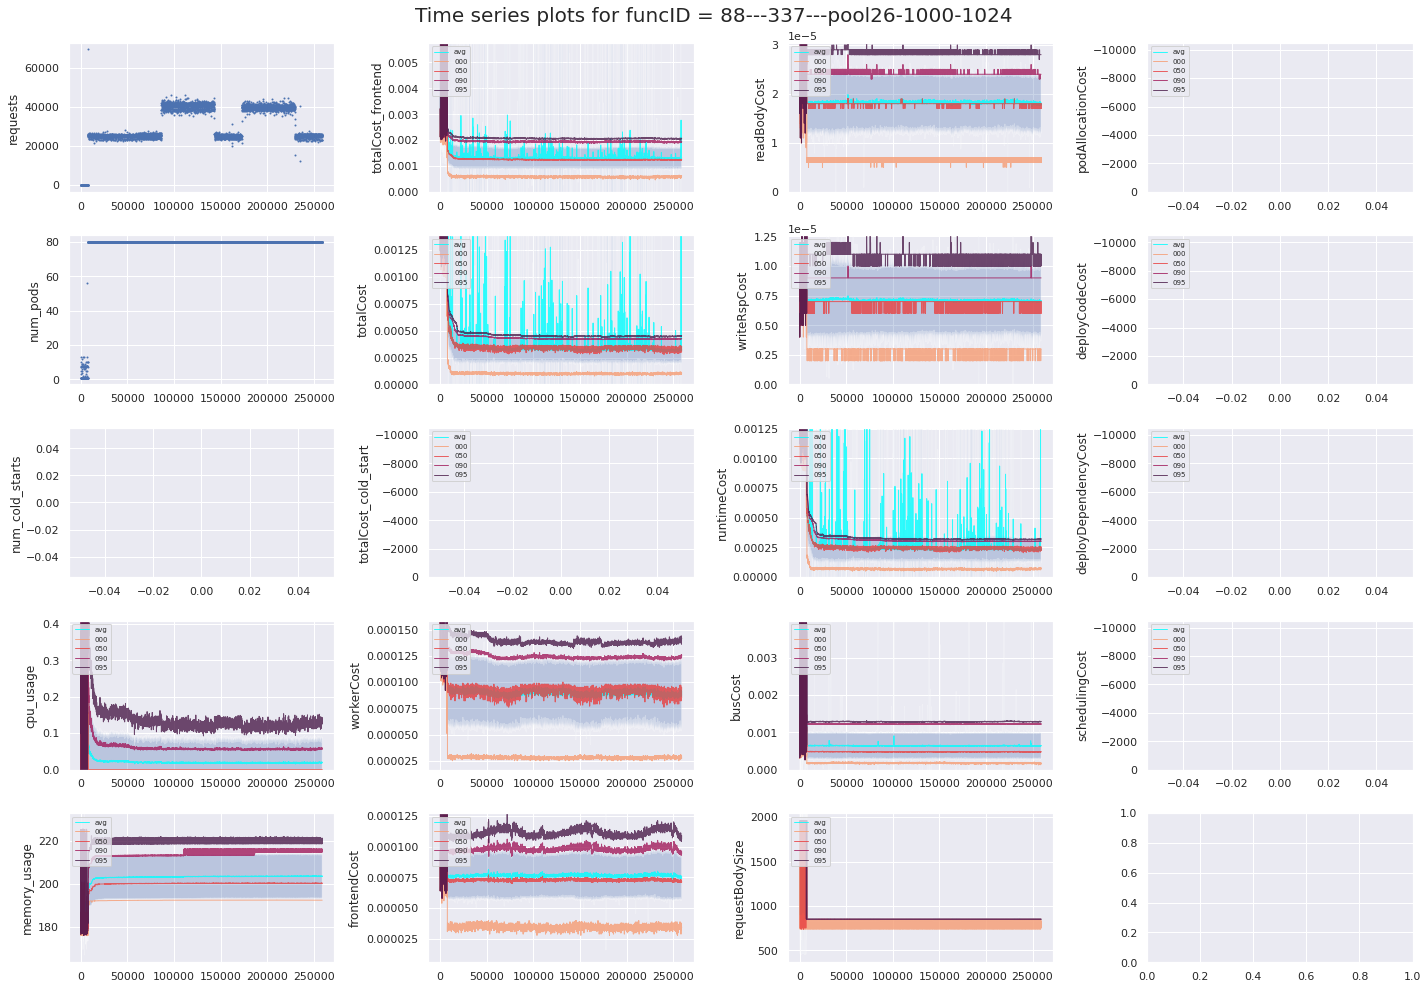

 20%|██        | 1/5 [00:04<00:19,  4.84s/it]/tmp/ipykernel_10084/3285403942.py:55: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


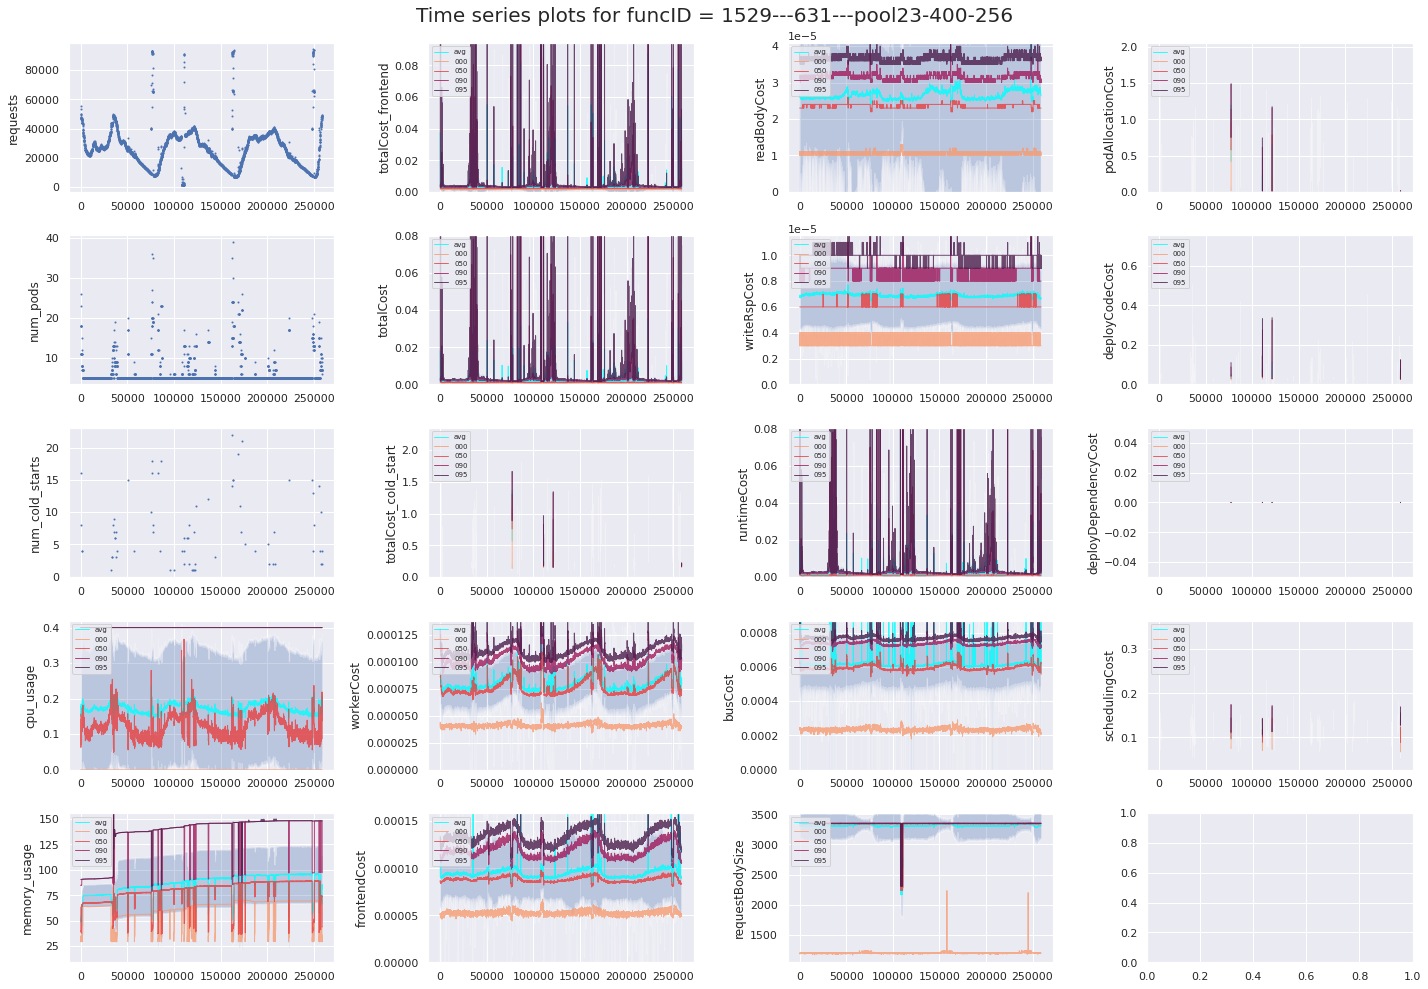

 40%|████      | 2/5 [00:09<00:14,  4.90s/it]/tmp/ipykernel_10084/3285403942.py:55: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


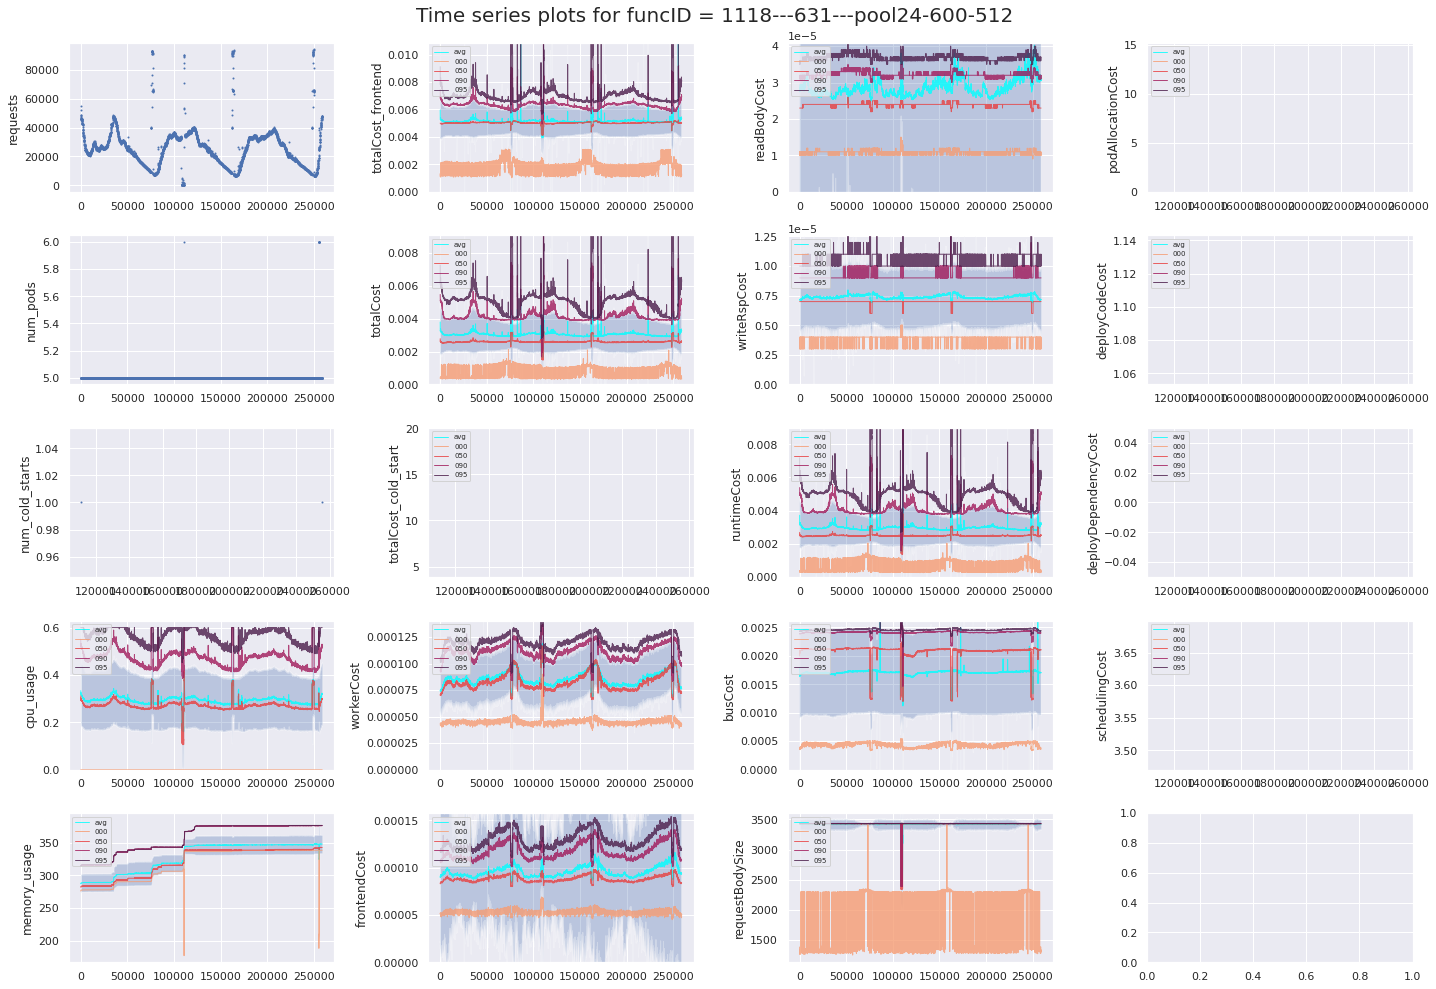

 60%|██████    | 3/5 [00:14<00:09,  4.90s/it]/tmp/ipykernel_10084/3285403942.py:55: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


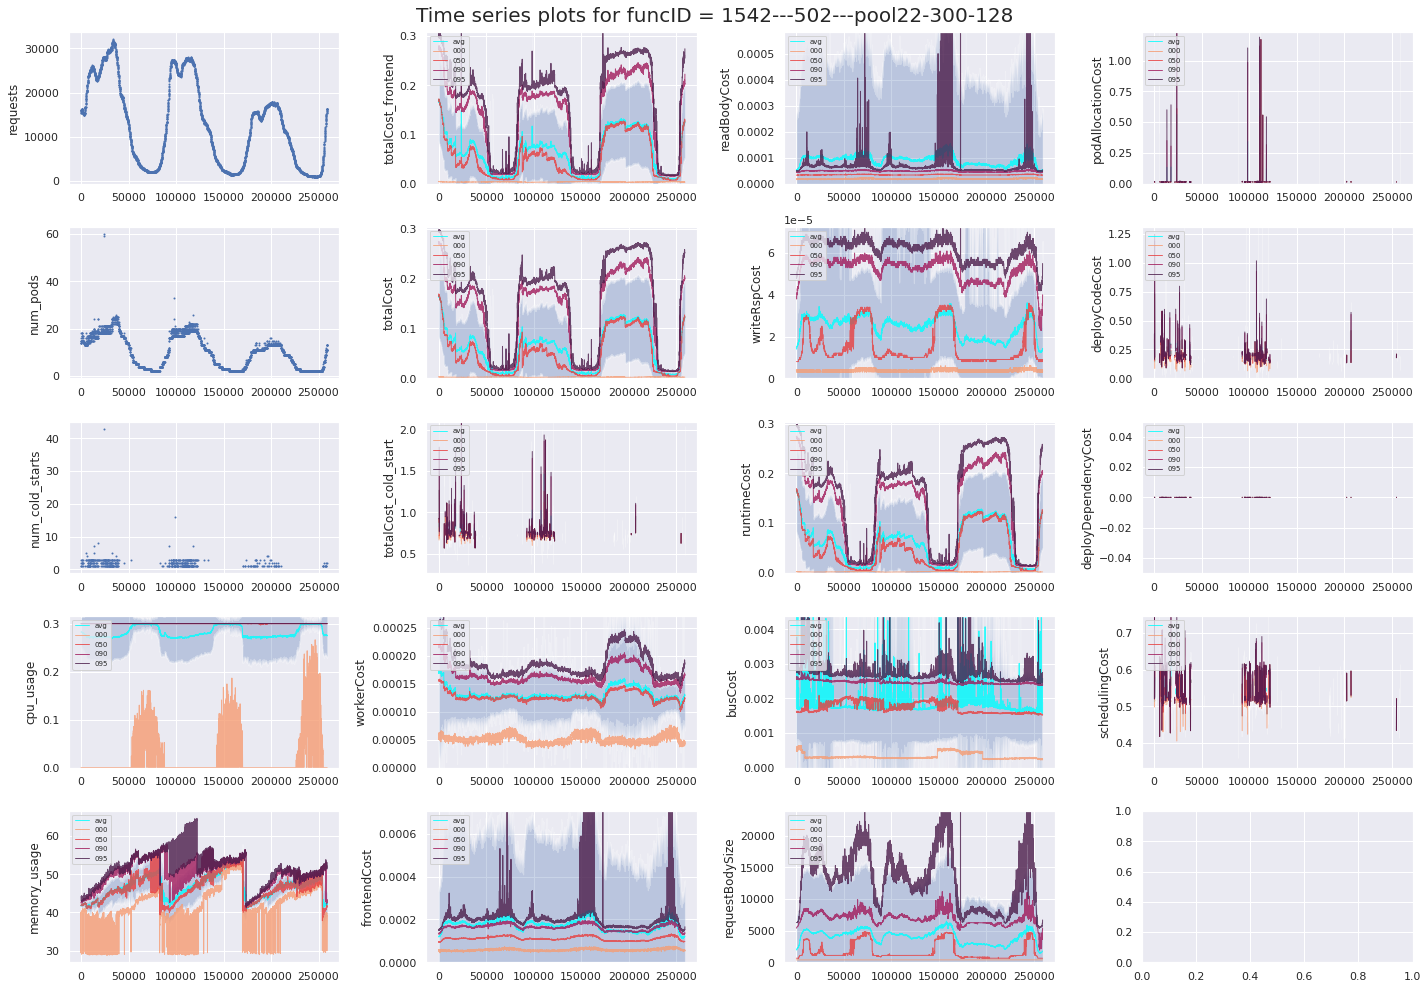

 80%|████████  | 4/5 [00:20<00:05,  5.15s/it]/tmp/ipykernel_10084/3285403942.py:55: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


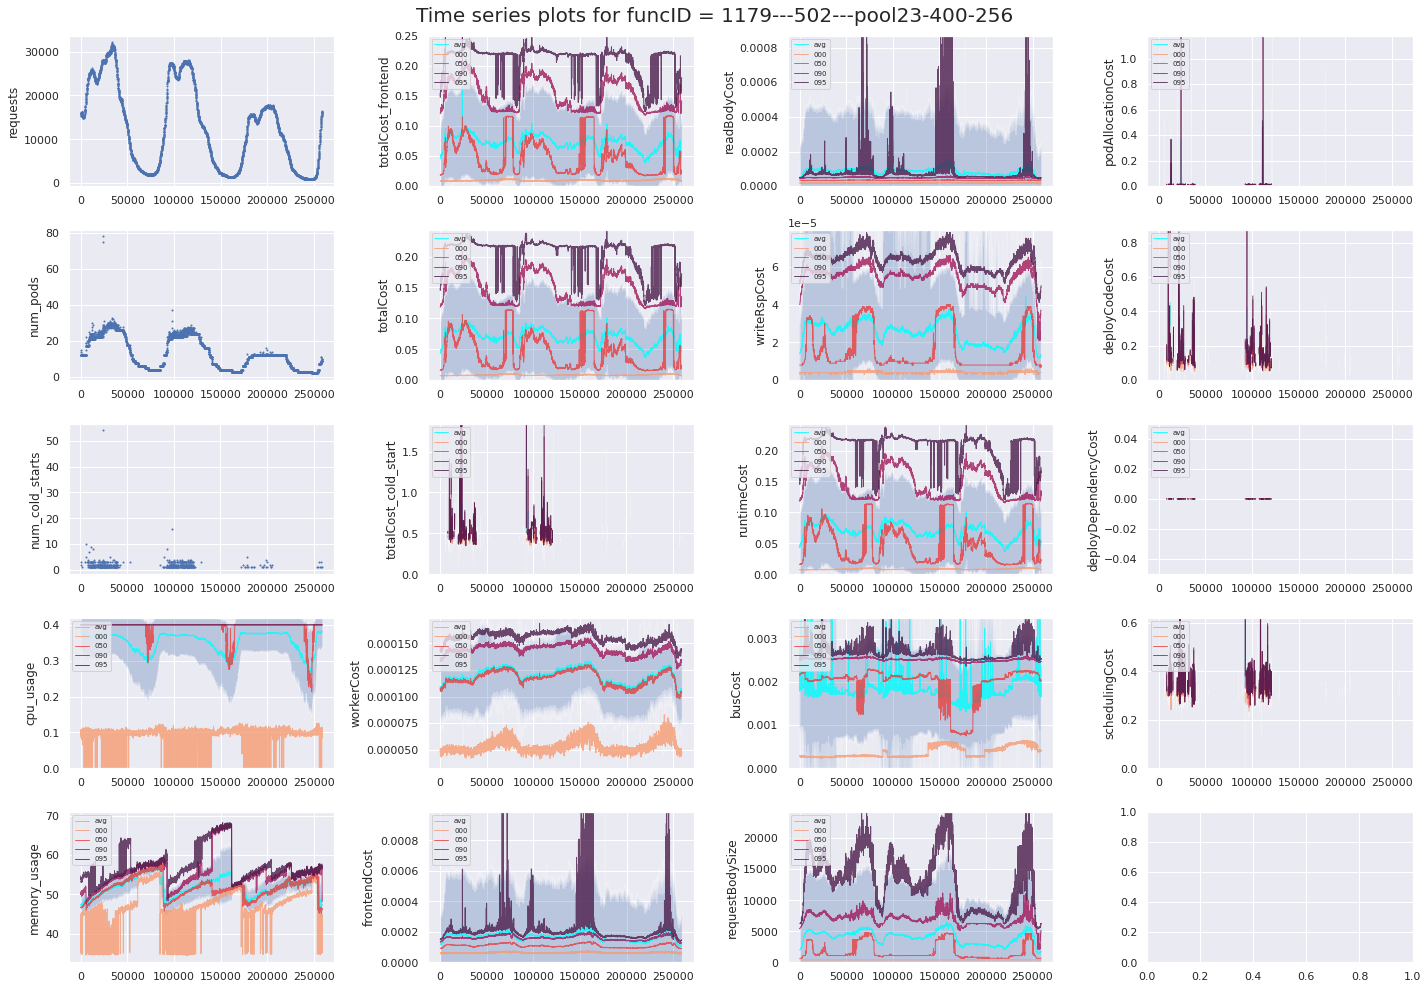

100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


In [9]:
# Plot time series plots with quantiles for top functions
with plt.rc_context({'figure.dpi': 72}):
    for funcID in tqdm(funcID_list):

        ordered_metrics_family_list = list(metrics_dict.keys())
        ordered_metrics_family_list = iter(ordered_metrics_family_list)

        # Create a 4-row subplot layout
        fig, ax = plt.subplots(5, 4, figsize=(20, 14))

        # Iterate over different metrics
        for col_idx in [0,1,2,3]:

            for row_idx in [0,1,2,3,4]:

                try:
                    metric_family = next(ordered_metrics_family_list)
                    metric_family_dict = metrics_dict[metric_family]

                    if len(metric_family_dict)==1:
                        df_i = metric_family_dict['sum']

                        ax[row_idx, col_idx].scatter(df_i['time'], df_i[funcID], s=1)
                        ax[row_idx, col_idx].set_ylabel(metric_family)

                    else:
                        
                        # Avg and std plots
                        ax[row_idx, col_idx].plot(metric_family_dict['avg']['time'], metric_family_dict['avg'][funcID], label = 'avg', c='cyan', alpha=0.8, linewidth=1)

                        std_upper = metric_family_dict['avg'][funcID] - metric_family_dict['std'][funcID]
                        std_lower = metric_family_dict['avg'][funcID] + metric_family_dict['std'][funcID]
                        ax[row_idx, col_idx].fill_between(metric_family_dict['avg']['time'], std_lower, std_upper, alpha=0.3, facecolor='b')
                        

                        # Quantile plots
                        q_list = sorted(metric_family_dict.keys())
                        q_list = [item for item in q_list if 'quantile' in item]
                        
                        max_ylim = -9999
                        c_list = sns.color_palette('rocket_r', len(q_list))
                        for i, q_i in enumerate(q_list):
                            df_q_i = metric_family_dict[q_i]
                            ax[row_idx, col_idx].plot(df_q_i['time'], df_q_i[funcID], label = q_i.replace('quantile_','').replace(metric_family,''), c=c_list[i], alpha=0.8, linewidth=1)
                            ax[row_idx, col_idx].set_ylabel(metric_family)

                            max_ylim_i = df_q_i[funcID].quantile(0.99)
                            if max_ylim<max_ylim_i:
                                max_ylim = max_ylim_i

                        ax[row_idx, col_idx].legend(loc = 'upper left', fontsize=7)             

                        ax[row_idx, col_idx].set_ylim(None, max_ylim*1.05)
                        if ax[row_idx, col_idx].get_ylim()[0]<0:
                            ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)
                except Exception as e:
                    print(e)
                    print('No metrics left\r')

        title_str = f'Time series plots for funcID = {funcID}'
        fig.suptitle(title_str, fontsize=20)

        plt.tight_layout()
        plt.show()

<a id="runtimetriggertype"></a>
## 3. Region 2 with runtimes and trigger types
This section explains how to load the runtime and trigger type information for Region 2, and how to join this with the other tables.

<a href="#top">[back to top]</a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from glob import glob
from tqdm import tqdm
import seaborn as sns
import gc
sns.set_theme()

In [2]:
# Define root for cold starts
rt_cold_start = '../datasets/cold_start_dataset/cold_start'

# Define root for runtime and trigger type file
rt_funcID_runtime_triggerType = '../datasets/cold_start_dataset/runtime_triggerType/df_funcID_runtime_triggerType.csv'

In [3]:
df_runtime_triggerType = pd.read_csv(rt_funcID_runtime_triggerType)
df_runtime_triggerType

,funcID,cpu_request,runtime,triggerType-invocationType
0,400---418---pool22-300-128,100,Python3,workflow-S
1,1531---418---pool22-300-128,100,Node.js,workflow-S
2,343---1077---pool22-300-128,100,Java,workflow-S
3,343---420---pool22-300-128,100,Java,workflow-S
4,343---1095---pool22-300-128,100,Java,workflow-S
...,...,...,...,...
2413,565---486---pool30-1800-2048,1000,http,APIG-S
2414,1060---777---pool23-400-256,125,Python3,unknown-unknown
2415,673---777---pool23-400-256,125,Python3,unknown-unknown
2416,1812---777---pool23-400-256,125,Python3,unknown-unknown


<a id="plottingruntimetriggertype"></a>
### 3.1. Plotting runtime and trigger type
Plot number of functions by runtime and trigger type. <a href="#top">[back to top]</a>

<Axes: title={'center': 'Number of functions by runtime'}, xlabel='runtime'>

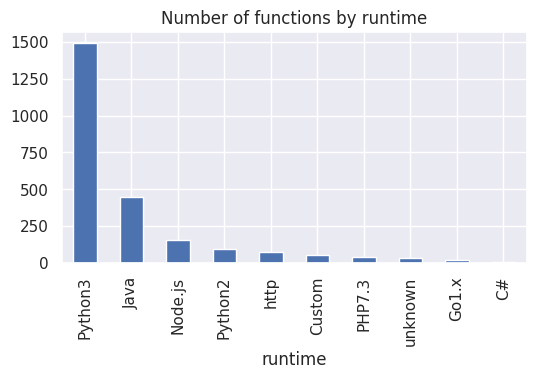

In [4]:
# Plot numeber of functions by runtime
df_runtime_triggerType['runtime'].value_counts(dropna=False).plot(kind='bar', figsize=(6,3), title='Number of functions by runtime')

<Axes: title={'center': 'Number of functions by trigger combination'}, xlabel='triggerType-invocationType'>

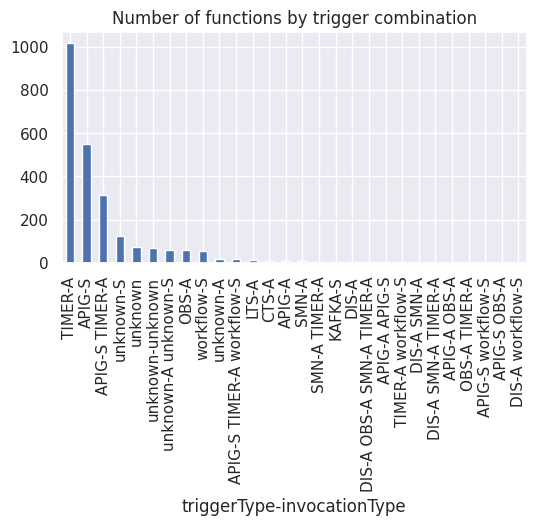

In [5]:
# Plot number of functions by trigger combination
df_runtime_triggerType['triggerType-invocationType'].value_counts(dropna=False).plot(kind='bar', figsize=(6,3), title='Number of functions by trigger combination')

<a id="runtimecdf"></a>
### 3.2. Plotting cold start CDF by runtime
This section shows how we can join the runtime and trigger type table with the cold start table. <a href="#top">[back to top]</a>

In [6]:
# Read cold starts for Region 2

filenames_list_i = sorted(glob(rt_cold_start+f'/R2/*.csv'))
dfs_list = []
for filename_i in tqdm(filenames_list_i):
    df_i = pd.read_csv(filename_i)
    dfs_list.append(df_i)
df_R2 = pd.concat(dfs_list)
df_R2['poolName'] = df_R2['podID'].str.split('-').str[:3].str.join('-')
df_R2['funcID'] = df_R2['funcName'].astype(str) + '---' + df_R2['userID'].astype(str) + '---' + df_R2['poolName']
df_R2

100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


,day,time,clusterName,funcName,userID,requestID,totalCost_cold_start,podAllocationCost,deployCodeCost,deployDependencyCost,schedulingCost,podID,poolName,funcID
0,0,0.323,1,979,1111,e8cc4228b32e4a8fcf7c164ca62cf5a1569305bb7d3121...,0.289404,0.000243,0.213,0.000,0.076161,pool22-300-128-0001562370,pool22-300-128,979---1111---pool22-300-128
1,0,0.328,2,743,418,f554e1c7fa2222b458d5764910e2d1ee3bccd2045fefce...,0.172102,0.000138,0.067,0.000,0.104964,pool22-300-128-0000600630,pool22-300-128,743---418---pool22-300-128
2,0,0.361,3,2028,481,58b18460d4fc4a6e8419f1f7bf6da422cc3671e747974f...,0.235527,0.000138,0.125,0.000,0.110389,pool22-300-128-0001444785,pool22-300-128,2028---481---pool22-300-128
3,0,0.362,3,167,296,f951318dc8f7e4b17ccb1fa907730aa95b3b36743a4327...,0.167989,0.000123,0.055,0.000,0.112866,pool22-300-128-0001443980,pool22-300-128,167---296---pool22-300-128
4,0,0.364,3,272,525,2a83c6c486f8e4b5efc798fb44f4401b5d16199f8eefd5...,0.215433,0.000152,0.074,0.000,0.141281,pool22-300-128-0001092850,pool22-300-128,272---525---pool22-300-128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63144,30,2678388.653,2,1607,923,fc8e24a3cf7fbce54ed3e24d99b11ed7933e4fd1cdffda...,0.597362,0.014675,0.136,0.000,0.446687,pool22-300-128-0000196449,pool22-300-128,1607---923---pool22-300-128
63145,30,2678390.987,1,612,63,ac3f447c0ee16ecf709eeab0260156efba024e15c5e7a6...,1.450608,0.007911,0.025,0.983,0.434697,pool22-300-128-0001377502,pool22-300-128,612---63---pool22-300-128
63146,30,2678391.260,1,612,63,fe7b641cb13d744d06ee954202df62dced52794b2a9504...,1.720289,0.007843,0.028,1.271,0.413446,pool22-300-128-0000044339,pool22-300-128,612---63---pool22-300-128
63147,30,2678391.320,1,612,63,9265d3477e5af0a8dde659dd878f7f1e58b4d699275a64...,1.793164,0.007897,0.052,1.217,0.516267,pool22-300-128-0001700101,pool22-300-128,612---63---pool22-300-128


In [7]:
# Merge with runtimes and trigger types based on funcID
df_R2 = pd.merge(left=df_R2, right=df_runtime_triggerType, on='funcID', how='left')
df_R2

,day,time,clusterName,funcName,userID,requestID,totalCost_cold_start,podAllocationCost,deployCodeCost,deployDependencyCost,schedulingCost,podID,poolName,funcID,cpu_request,runtime,triggerType-invocationType
0,0,0.323,1,979,1111,e8cc4228b32e4a8fcf7c164ca62cf5a1569305bb7d3121...,0.289404,0.000243,0.213,0.000,0.076161,pool22-300-128-0001562370,pool22-300-128,979---1111---pool22-300-128,100,Python3,workflow-S
1,0,0.328,2,743,418,f554e1c7fa2222b458d5764910e2d1ee3bccd2045fefce...,0.172102,0.000138,0.067,0.000,0.104964,pool22-300-128-0000600630,pool22-300-128,743---418---pool22-300-128,100,Node.js,workflow-S
2,0,0.361,3,2028,481,58b18460d4fc4a6e8419f1f7bf6da422cc3671e747974f...,0.235527,0.000138,0.125,0.000,0.110389,pool22-300-128-0001444785,pool22-300-128,2028---481---pool22-300-128,100,Node.js,TIMER-A
3,0,0.362,3,167,296,f951318dc8f7e4b17ccb1fa907730aa95b3b36743a4327...,0.167989,0.000123,0.055,0.000,0.112866,pool22-300-128-0001443980,pool22-300-128,167---296---pool22-300-128,100,Node.js,TIMER-A
4,0,0.364,3,272,525,2a83c6c486f8e4b5efc798fb44f4401b5d16199f8eefd5...,0.215433,0.000152,0.074,0.000,0.141281,pool22-300-128-0001092850,pool22-300-128,272---525---pool22-300-128,100,Python3,TIMER-A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072818,30,2678388.653,2,1607,923,fc8e24a3cf7fbce54ed3e24d99b11ed7933e4fd1cdffda...,0.597362,0.014675,0.136,0.000,0.446687,pool22-300-128-0000196449,pool22-300-128,1607---923---pool22-300-128,100,Python3,TIMER-A
2072819,30,2678390.987,1,612,63,ac3f447c0ee16ecf709eeab0260156efba024e15c5e7a6...,1.450608,0.007911,0.025,0.983,0.434697,pool22-300-128-0001377502,pool22-300-128,612---63---pool22-300-128,100,Python3,workflow-S
2072820,30,2678391.260,1,612,63,fe7b641cb13d744d06ee954202df62dced52794b2a9504...,1.720289,0.007843,0.028,1.271,0.413446,pool22-300-128-0000044339,pool22-300-128,612---63---pool22-300-128,100,Python3,workflow-S
2072821,30,2678391.320,1,612,63,9265d3477e5af0a8dde659dd878f7f1e58b4d699275a64...,1.793164,0.007897,0.052,1.217,0.516267,pool22-300-128-0001700101,pool22-300-128,612---63---pool22-300-128,100,Python3,workflow-S


In [8]:
# Check how many cold starts we have per runtime
df_R2['runtime'].value_counts(dropna=False)

runtime
Python3    1190731
Node.js     287253
Custom      186452
Java        165695
Python2     165673
Go1.x        30045
PHP7.3       25591
http         18167
C#            3105
unknown        111
Name: count, dtype: int64

<Axes: xlabel='totalCost_cold_start', ylabel='Probability'>

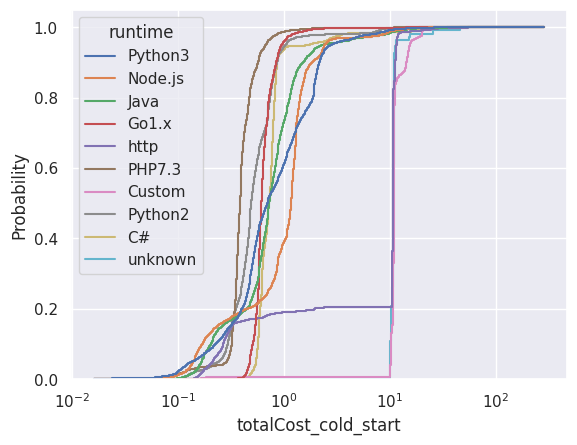

In [9]:
# CDF of cold start time by runtime language
sns.histplot(data=df_R2, 
             bins=500,
             fill=False,
             element="step",
             x='totalCost_cold_start', 
             hue='runtime', 
             stat='probability', 
             cumulative=True, 
             log_scale=[True,False], 
             common_norm=False)

<a id="perrequest"></a>
## 4. Per request analysis
This section explains how to analyze the request-level logs. The code below works for smaller regions. For larger regions, you may have to use PySpark or other big data tools.

<a href="#top">[back to top]</a>

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from glob import glob
from tqdm import tqdm
import seaborn as sns
import gc
sns.set_theme()

In [11]:
# Select region
region = 'R5'

In [12]:
# Select root to read csv files from
rt = f'../datasets/cold_start_dataset/per_request/{region}/*.csv'

In [13]:
# Get file names
filenames_list = sorted(glob(rt))
print(f'Found {len(filenames_list)} per request files')

Found 200 per request files


In [14]:
# Read files
dfs_list = []
for filename_i in tqdm(filenames_list):
    df_i = pd.read_csv(filename_i)
    dfs_list.append(df_i)
df = pd.concat(dfs_list)
df

100%|██████████| 200/200 [00:10<00:00, 18.54it/s]


,time_worker,time_frontend,requestID,clusterName,funcName,podID,userID,totalCost_worker,workerCost,runtimeCost,totalCost_frontend,frontendCost,busCost,readBodyCost,writeRspCost,cpu_usage,memory_usage,requestBodySize
0,2592000.020,2592000.021,b54cf4cd859e62637c91fd47cef816f291a9efec3b9d17...,3,411,pool22-300-128-0000177166,301,0.000931,0.000103,0.000829,0.002367,0.000531,0.000585,0.000025,0.000009,0.059806,34.238280,2.0
1,2592000.034,2592000.037,987863989fbd048b38594549e69b7c7f4b102d3543e663...,3,34,pool22-300-128-0000014767,83,0.001416,0.000646,0.000770,0.011992,0.000377,0.009904,0.000018,0.000008,0.000000,26.699219,120.0
2,2592000.040,2592000.041,60a99140327936a024c9329aba7b4fd5313eedd8b16e14...,3,329,pool22-300-128-0000331366,301,0.000823,0.000131,0.000692,0.003945,0.002248,0.000540,0.000021,0.000008,0.000000,26.652344,2.0
3,2592000.052,2592000.052,cfe3d0a027c55dd500d9c49a1d4be156e789dfc4e062be...,4,296,pool22-300-128-0000618412,224,0.019952,0.000124,0.019828,0.022946,0.000444,0.002194,0.000024,0.000009,0.290779,32.304688,979.0
4,2592000.066,2592000.066,bdf1779d87d3dc9cee9ded2df86d33dcef0c95a94c872b...,4,296,pool22-300-128-0000773449,224,0.034748,0.000143,0.034605,0.037435,0.000556,0.001785,0.000033,0.000013,0.219951,32.378906,979.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16157,2678398.958,NaN,bdea9699d7062c7a530b63f49e14b9c2864cc0a9621084...,4,296,pool22-300-128-0000206093,224,0.027996,0.000100,0.027896,NaN,NaN,NaN,NaN,NaN,0.231319,32.324220,NaN
16158,2678398.995,NaN,6097886824be9995d96b84f5baa926a0c1f89048746c81...,4,296,pool22-300-128-0000206093,224,0.036471,0.000103,0.036368,NaN,NaN,NaN,NaN,NaN,0.179856,32.324220,NaN
16159,2678399.020,NaN,dcd6ca5c39280d164f0e32d758baf77b09e182131ec6b7...,4,296,pool22-300-128-0000206093,224,0.024943,0.000103,0.024840,NaN,NaN,NaN,NaN,NaN,0.238961,32.324220,NaN
16160,2678399.048,NaN,f0c9211944e6cf928d880f395229a47302f3b1eef5d8fe...,4,296,pool22-300-128-0000206093,224,0.027543,0.000100,0.027444,NaN,NaN,NaN,NaN,NaN,0.254372,32.324220,NaN


In [15]:
# Show data types per column
df.dtypes

time_worker           float64
time_frontend         float64
requestID              object
clusterName             int64
funcName                int64
podID                  object
userID                  int64
totalCost_worker      float64
workerCost            float64
runtimeCost           float64
totalCost_frontend    float64
frontendCost          float64
busCost               float64
readBodyCost          float64
writeRspCost          float64
cpu_usage             float64
memory_usage          float64
requestBodySize       float64
dtype: object

<a id="perrequestdask"></a>
## 5. Per-request analysis with Dask
For larger regions or more complex tasks, you may want to use Dask. Dask is a parallelized library with a similar user interface to Pandas and NumPy. Dask is straightforward to <a href='https://docs.dask.org/en/stable/install.html'> install using only pip or conda</a>. This will let you speed up your local setup. Dask code can also be deployed to a cluster.

<a href="#top">[back to top]</a>

In [1]:
import dask
import dask.dataframe as dd
import dask.array as da
import numpy as np
from matplotlib import pyplot as plt
import time
import seaborn as sns

In [2]:
# Select region
region = 'R1'

In [2]:
# Select root to read csv files from
rt = f'../datasets/cold_start_dataset/per_request/'

<a id="perrequestcdf"></a>
### 5.1. Per-request level CDF
This section shows how to efficiently plot the CDF of a metric at the per-event level. For example, we can plot the totalCost_worker metric at a per-request granularity in a region.

In [4]:
# Select metric we want to analyze
metric_name = 'totalCost_worker'

In [5]:
# Record start time
start_time = time.time()

In [6]:
# Read directory of csv files 
# We pass assume_missing=True in case there are some NaN values in this column
# To simplify things, we only need to read the columns we want to analyze
df = dd.read_csv(f'{rt}/{region}/*.csv', assume_missing=True, usecols=[metric_name])

In [7]:
# We want to define the minimum and maximum value of this metric so that we can create our bins later
min_value = df[metric_name].min()
max_value = df[metric_name].max()

# Call .compute() on the lazy objects we defined earlier to actually calculate the min_value and max_value
min_value, max_value = dask.compute(min_value, max_value)
print(f'min_value={min_value}')
print(f'max_value={max_value}')

min_value=0.000316
max_value=43135.973


In [8]:
# Compute log-spaced bin edges
num_bins = 200      # Set number of bins
eps = 1e-3          # Small safety factor.
log_bin_edges = np.logspace(np.log10(min_value)-eps, np.log10(max_value)+eps, num_bins)

In [9]:
# Define dask distogram
hist_values, bin_edges = da.histogram(df[metric_name], bins=log_bin_edges)

In [10]:
# Compute cumulative sum and normalize
cdf_values = np.cumsum(hist_values) / hist_values.sum()

In [11]:
# Call .compute() to compute values
hist_values, cdf_values = dask.compute(hist_values, cdf_values)

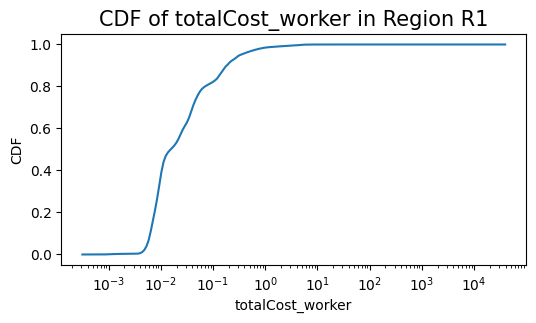

In [12]:
# Plot CDF of metric
plt.figure(figsize=(6,3))
plt.plot(bin_edges[:-1], cdf_values)
plt.xscale('log')
title_str = f'CDF of {metric_name} in Region {region}'
plt.title(title_str, fontsize=15)
plt.xlabel(metric_name)
plt.ylabel('CDF')
plt.show()

In [13]:
# Record end time
end_time = time.time()

In [14]:
# Calculate elapsed time and print
elapsed_time = end_time - start_time
# Convert elapsed time into minutes and seconds
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
# Print elapsed time in minutes and seconds
print(f"Time to compute CDF for {region}: {minutes} min {seconds} seconds")

Time to compute CDF for R1: 5 min 12 seconds


In [15]:
# Print number of requests
num_requests = df.shape[0].compute()
print(f'{region} contains {num_requests:,} requests')

R1 contains 364,210,340 requests


In [16]:
hist_values.sum()

np.int64(364210340)

<a id="requestgrouping"></a>
### 5.2. Grouping per-request logs by funcID

This section shows how to group metrics by funcID to count the number of requests or pods per function using Dask. 

<a href="#top">[back to top]</a>

In [6]:
# Select region
region = 'R5'

In [7]:
# Read dataframe with relevant columns
df_requests = dd.read_csv(f'{rt}/{region}/*.csv', usecols=['funcName', 'userID', 'podID'])

In [8]:
# Create the 'poolName' column by splitting 'podID' and joining the first 3 items with '-'
df_requests['poolName'] = df_requests['podID'].map(lambda x: '-'.join(x.split('-')[:3]), meta=('podID', 'object'))

In [9]:
# Create the 'funcID' column by concatenating 'funcName', 'userID', and 'poolName' with '---' separator
df_requests['funcID'] = df_requests['funcName'].astype(str) + '---' + df_requests['userID'].astype(str) + '---' + df_requests['poolName']

In [10]:
# Compute number of unique podIDs per funcID
unique_podIDs_per_funcID = df_requests.groupby('funcID')['podID'].nunique().compute().reset_index()
unique_podIDs_per_funcID

,funcID,podID
0,159---98---pool22-300-128,2
1,174---155---pool24-600-512,48
2,218---265---pool22-300-128,2
3,453---136---pool22-300-128,1
4,176---37---pool22-300-128,2
...,...,...
486,482---155---pool23-400-256,48
487,327---108---pool22-300-128,2
488,491---360---pool22-300-128,2
489,279---239---pool22-300-128,2


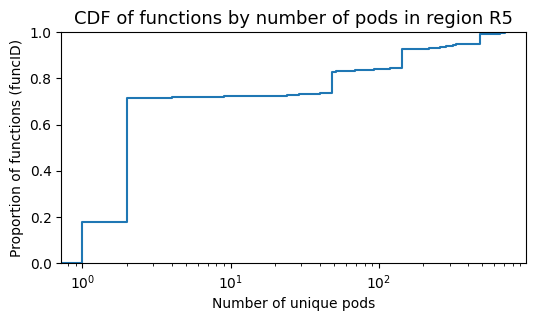

In [11]:
# Plot CDF
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.ecdfplot(unique_podIDs_per_funcID['podID'], ax=ax)
plt.xscale('log')
plt.ylabel('Proportion of functions (funcID)')
plt.xlabel('Number of unique pods')
title_str = f'CDF of functions by number of pods in region {region}'
plt.title(title_str, fontsize=13)
plt.show()

In [12]:
# Print stats
unique_podIDs_per_funcID.describe()

,podID
count,491.000000
mean,51.698574
std,121.715555
min,1.000000
25%,2.000000
50%,2.000000
75%,48.000000
max,711.000000


In [13]:
# Count the number of rows (requests) per funcID 
func_counts = df_requests.groupby('funcID').size().compute()

In [14]:
# Compute number of requests per funcID
df_func_counts = func_counts.to_frame(name='num_requests').reset_index()
df_func_counts['num_requests'] = df_func_counts['num_requests'].astype(int)
df_func_counts

,funcID,num_requests
0,142---60---pool22-300-128,1440
1,525---27---pool22-300-128,480
2,532---301---pool22-300-128,1440
3,62---124---pool22-300-128,1
4,7---155---pool22-300-128,144
...,...,...
486,192---285---pool22-300-128,2
487,414---20---pool22-300-128,2
488,128---202---pool22-300-128,3
489,468---22---pool22-300-128,2


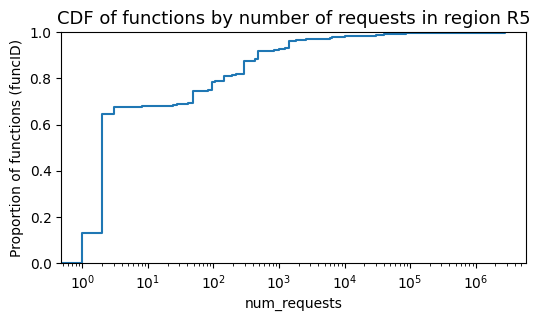

In [15]:
# Plot CDF
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.ecdfplot(df_func_counts['num_requests'], ax=ax)
plt.xscale('log')
plt.ylabel('Proportion of functions (funcID)')
title_str = f'CDF of functions by number of requests in region {region}'
plt.title(title_str, fontsize=13)
plt.show()